## 02. 회원여부 및 상태
- '회원여부_이용가능', '회원여부_이용가능_CA', '회원여부_이용가능_카드론', '회원여부_연체'
- '이용거절여부_카드론', '동의여부_한도증액안내', '마케팅동의여부'


In [1]:
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import seaborn as sns

# Mac에서는 "AppleGothic" 사용
plt.rcParams['font.family'] = 'AppleGothic'
plt.rcParams['axes.unicode_minus'] = False  # 마이너스 깨짐 방지

In [7]:
import pandas as pd

# 분석에 필요한 컬럼만 지정
usecols = ["회원여부_이용가능", "회원여부_이용가능_CA", "회원여부_이용가능_카드론",
    "회원여부_연체", "이용거절여부_카드론", "동의여부_한도증액안내", "마케팅동의여부", "Segment", "ID"]

# 필요한 컬럼만 불러오기
df = pd.read_csv("../data/train/1.회원정보/train_회원정보.csv", usecols=usecols)

print(df.head())

             ID Segment  회원여부_이용가능  회원여부_이용가능_CA  회원여부_이용가능_카드론  회원여부_연체  \
0  TRAIN_000000       D          1             1              0        0   
1  TRAIN_000001       E          1             1              1        0   
2  TRAIN_000002       C          1             1              0        0   
3  TRAIN_000003       D          1             1              0        0   
4  TRAIN_000004       E          1             1              1        0   

   이용거절여부_카드론  동의여부_한도증액안내  마케팅동의여부  
0           0            1        1  
1           0            0        1  
2           0            1        1  
3           0            1        1  
4           0            0        1  


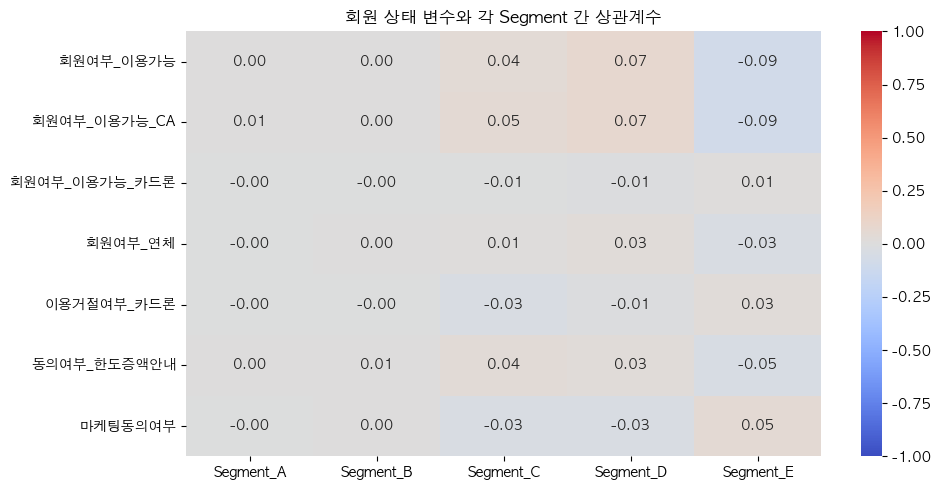

In [9]:
selected_columns = [
    "회원여부_이용가능", "회원여부_이용가능_CA", "회원여부_이용가능_카드론",
    "회원여부_연체", "이용거절여부_카드론", "동의여부_한도증액안내", "마케팅동의여부"
]

# Segment 더미 생성
segment_dummies_small = pd.get_dummies(df["Segment"], prefix="Segment")[["Segment_A", "Segment_B", "Segment_C", "Segment_D", "Segment_E"]]

# 필요한 열만 결합
df_small = pd.concat([df[selected_columns], segment_dummies_small], axis=1)

# 상관계수 계산
corr_small = df_small.corr()

# Segment 열과 다른 변수들 간 상관관계만 추출
segment_corr_small = corr_small.loc[selected_columns, segment_dummies_small.columns]

# 시각화
plt.figure(figsize=(10, 5))
sns.heatmap(segment_corr_small, annot=True, cmap="coolwarm", fmt=".2f", vmax=1, vmin=-1)
plt.title("회원 상태 변수와 각 Segment 간 상관계수")
plt.tight_layout()
plt.show()

In [11]:
segment_group_mean = df.groupby("Segment")[selected_columns].mean()
segment_group_mean

,회원여부_이용가능,회원여부_이용가능_CA,회원여부_이용가능_카드론,회원여부_연체,이용거절여부_카드론,동의여부_한도증액안내,마케팅동의여부
Segment,,,,,,,
A,1.000000,0.987654,0.612140,0.014403,0.162551,0.130658,0.757202
B,1.000000,0.958333,0.402778,0.041667,0.069444,0.340278,0.875000
C,0.992546,0.945466,0.605972,0.023427,0.139572,0.147331,0.756854
D,0.989517,0.938229,0.607939,0.026042,0.185908,0.117809,0.778804
E,0.943182,0.865140,0.624781,0.015030,0.203599,0.091764,0.819227


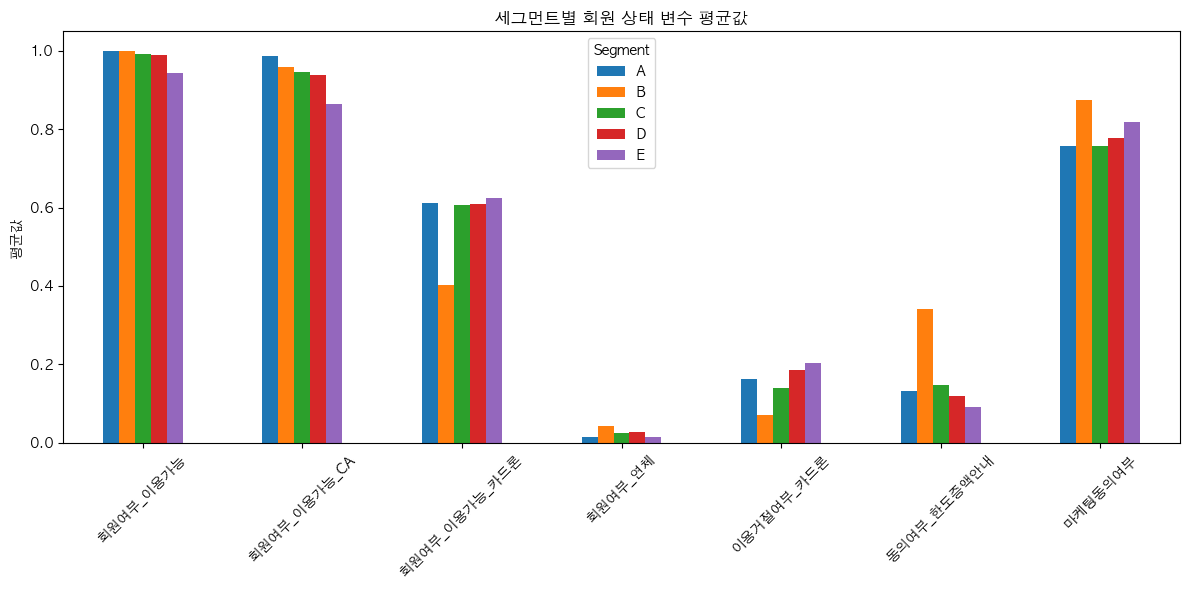

In [13]:
segment_group_mean.T.plot(kind="bar", figsize=(12, 6))
plt.title("세그먼트별 회원 상태 변수 평균값")
plt.ylabel("평균값")
plt.xticks(rotation=45)
plt.legend(title="Segment")
plt.tight_layout()
plt.show()

- B: 카드론 기능 이용 제약 많음 -> 한도증액 마케팅에 가장 민감
    - 그치만 거절 여부도 낮아서 애초에 카드론 신청을 안했을 가능성 있음

In [25]:
# 각 Segment에서 해당 컬럼이 1인 비율 계산
binary_cols = usecols[2:]
segment_distribution = {}

for col in binary_cols:
    segment_percent = df[df[col] == 1]["Segment"].value_counts(normalize=True).sort_index()
    segment_distribution[col] = (segment_percent * 100).round(2)

# 결과를 DataFrame으로 변환 (행: 변수, 열: Segment)
result_df = pd.DataFrame(segment_distribution).T
result_df.columns.name = "Segment"

print(result_df)

Segment           A     B     C      D      E
회원여부_이용가능_카드론  0.04  0.00  5.18  14.24  80.53
회원여부_연체        0.03  0.01  7.29  22.19  70.47
이용거절여부_카드론     0.03  0.00  3.76  13.69  82.52
동의여부_한도증액안내    0.05  0.02  7.95  17.40  74.58
마케팅동의여부        0.04  0.01  4.97  13.99  81.00
Segment         NaN   NaN   NaN    NaN    NaN
ID              NaN   NaN   NaN    NaN    NaN


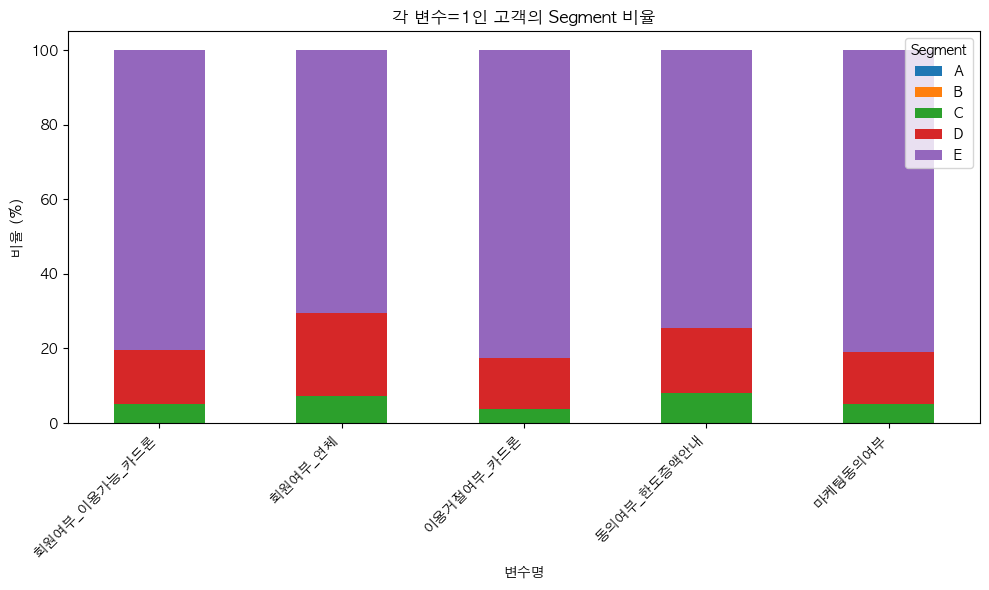

In [27]:
import matplotlib.pyplot as plt

# 누락된 'Segment', 'ID' 제거
plot_df = result_df.drop(['Segment', 'ID'], errors='ignore')

# 전치해서 시각화 (행: 변수, 열: Segment → bar로 보기 좋음)
plot_df.plot(kind='bar', stacked=True, figsize=(10, 6))
plt.title("각 변수=1인 고객의 Segment 비율")
plt.ylabel("비율 (%)")
plt.xlabel("변수명")
plt.legend(title="Segment")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

📊 연체 여부에 따른 한도증액안내 동의율 (%)


,비동의,동의
연체 없음,90.262263,9.737737
연체 있음,83.460187,16.539813


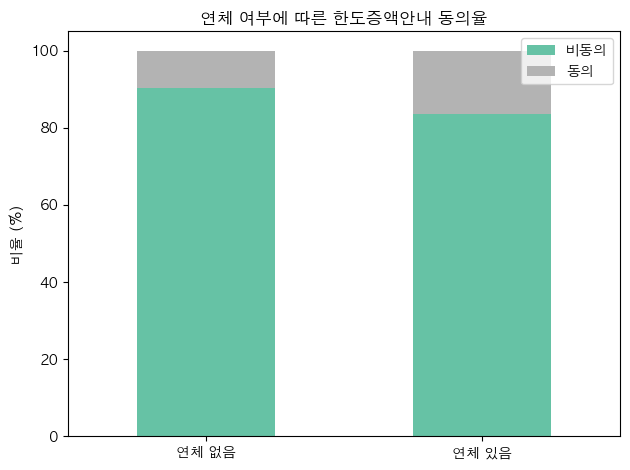

In [29]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 1. 연체 여부에 따른 마케팅 동의율 계산
crosstab = pd.crosstab(df['회원여부_연체'], df['동의여부_한도증액안내'], normalize='index') * 100
crosstab.columns = ['비동의', '동의']
crosstab.index = ['연체 없음', '연체 있음']
print("📊 연체 여부에 따른 한도증액안내 동의율 (%)")
display(crosstab)

# 2. 시각화
crosstab.plot(kind='bar', stacked=True, colormap='Set2')
plt.title("연체 여부에 따른 한도증액안내 동의율")
plt.ylabel("비율 (%)")
plt.xticks(rotation=0)
plt.legend(loc="upper right")
plt.tight_layout()
plt.show()

- 연체 있으면 한도증액안내 동의 많이함